<a href="https://colab.research.google.com/github/zumaia/Data-Analysis-and-Machine-Learning-Projects/blob/master/ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip -q install transformers
from transformers import AutoTokenizer, AutoModelForQuestionAnswering


     |████████████████████████████████| 2.1MB 17.3MB/s 
     |████████████████████████████████| 890kB 55.6MB/s 
     |████████████████████████████████| 3.2MB 46.4MB/s 


# Use the model DialoGPT-small



In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")

In [ ]:
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
# append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
# generated a response while limiting the total chat history to 1000 tokens    
    chat_history_ids = model.generate(
    bot_input_ids, max_length=1000,
    pad_token_id=tokenizer.eos_token_id
    )
# pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:bye
DialoGPT: I'm sorry, I'm not sorry.
>> User:okey?
DialoGPT: I'm sorry, I'm not sorry.
>> User:hello
DialoGPT: I'm sorry, I'm not sorry.
>> User:bye
DialoGPT: I'm sorry, I'm sorry.
>> User:bye
DialoGPT: I'm sorry, I'm sorry.


https://towardsdatascience.com/make-your-own-rick-sanchez-bot-with-transformers-and-dialogpt-fine-tuning-f85e6d1f4e30


# Nuestro ChatBot modificado :) Hablemos con Rick de "Rick and Morty"

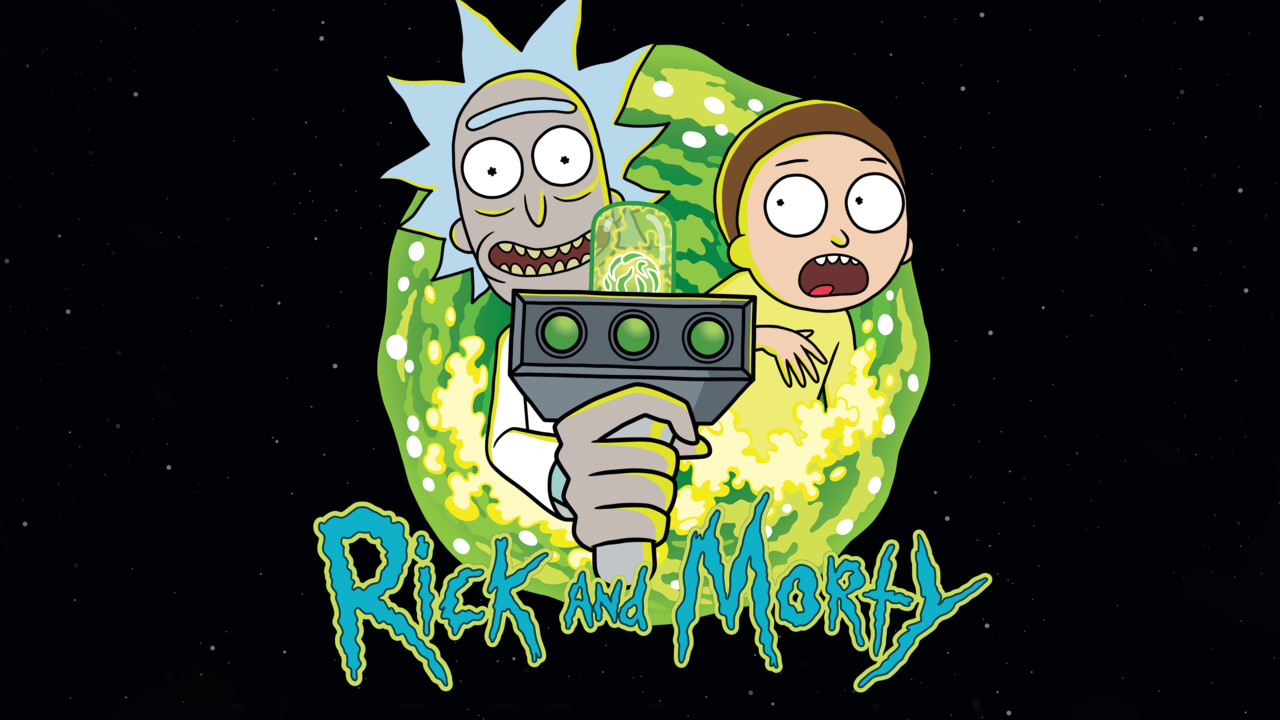

# Fine tuning

In [ ]:
# @title Librerias y paquetes a instalar
"""
Fine-tuning the library models for language modeling on a text file (GPT, GPT-2, BERT, RoBERTa).
GPT and GPT-2 are fine-tuned using a causal language modeling (CLM) loss while BERT and RoBERTa are fine-tuned
using a masked language modeling (MLM) loss.
"""

import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# Configs
logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [ ]:
# @title Clase args
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [ ]:
all_rick = pd.read_csv('https://raw.githubusercontent.com/apolmig/AppliedAI_basic/master/chatbots/RickAndMortyScripts.csv')

all_rick.head(10)

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."
5,5,1,1,Pilot,Morty,Ow! Ow! You're tugging me too hard!
6,6,1,1,Pilot,Rick,"We gotta go, gotta get outta here, come on. Go..."
7,7,1,1,Pilot,Rick,"What do you think of this... flying vehicle, M..."
8,8,1,1,Pilot,Morty,"Yeah, Rick... I-it's great. Is this the surprise?"
9,9,1,1,Pilot,Rick,Morty. I had to... I had to do it. I had— I ha...


In [ ]:
contexted = []
n = 7
for i in range(n, len(all_rick['line'])):
  row = []
  prev = i - 1 - n # we additionally subtract 1, so row will contain current response and 7 previous responses  
  for j in range(i, prev, -1):
    row.append(all_rick['line'][j])
  contexted.append(row)
columns = ['response', 'context'] 
columns = columns + ['context/'+str(i) for i in range(n-1)]
df = pd.DataFrame.from_records(contexted, columns=columns)
df.head(5)

,response,context,context/0,context/1,context/2,context/3,context/4,context/5
0,"What do you think of this... flying vehicle, M...","We gotta go, gotta get outta here, come on. Go...",Ow! Ow! You're tugging me too hard!,"Come on, I got a surprise for you. Come on, h...",It's the middle of the night. What are you tal...,"I got a surprise for you, Morty.","What, Rick? What’s going on?",Morty! You gotta come on. Jus'... you gotta co...
1,"Yeah, Rick... I-it's great. Is this the surprise?","What do you think of this... flying vehicle, M...","We gotta go, gotta get outta here, come on. Go...",Ow! Ow! You're tugging me too hard!,"Come on, I got a surprise for you. Come on, h...",It's the middle of the night. What are you tal...,"I got a surprise for you, Morty.","What, Rick? What’s going on?"
2,Morty. I had to... I had to do it. I had— I ha...,"Yeah, Rick... I-it's great. Is this the surprise?","What do you think of this... flying vehicle, M...","We gotta go, gotta get outta here, come on. Go...",Ow! Ow! You're tugging me too hard!,"Come on, I got a surprise for you. Come on, h...",It's the middle of the night. What are you tal...,"I got a surprise for you, Morty."
3,What?! A bomb?!,Morty. I had to... I had to do it. I had— I ha...,"Yeah, Rick... I-it's great. Is this the surprise?","What do you think of this... flying vehicle, M...","We gotta go, gotta get outta here, come on. Go...",Ow! Ow! You're tugging me too hard!,"Come on, I got a surprise for you. Come on, h...",It's the middle of the night. What are you tal...
4,We're gonna drop it down there just get a whol...,What?! A bomb?!,Morty. I had to... I had to do it. I had— I ha...,"Yeah, Rick... I-it's great. Is this the surprise?","What do you think of this... flying vehicle, M...","We gotta go, gotta get outta here, come on. Go...",Ow! Ow! You're tugging me too hard!,"Come on, I got a surprise for you. Come on, h..."


In [ ]:
trn_df, val_df = train_test_split(df, test_size = 0.1)


In [ ]:
# @title Dataset
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)
      
# Cacheing and storing of data/checkpoints

def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted

def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    # Check if we should delete older checkpoint(s)
    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [ ]:
# @title Train
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
  """ Train the model """
  if args.local_rank in [-1, 0]:
      tb_writer = SummaryWriter()

  args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

  def collate(examples: List[torch.Tensor]):
      if tokenizer._pad_token is None:
          return pad_sequence(examples, batch_first=True)
      return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

  train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
  train_dataloader = DataLoader(
      train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
  )

  if args.max_steps > 0:
      t_total = args.max_steps
      args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
  else:
      t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

  model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
  model.resize_token_embeddings(len(tokenizer))
  # add_special_tokens_(model, tokenizer)


  # Prepare optimizer and schedule (linear warmup and decay)
  no_decay = ["bias", "LayerNorm.weight"]
  optimizer_grouped_parameters = [
      {
          "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
          "weight_decay": args.weight_decay,
      },
      {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
  )

  # Check if saved optimizer or scheduler states exist
  if (
      args.model_name_or_path
      and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
      and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
  ):
      # Load in optimizer and scheduler states
      optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
      scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

  if args.fp16:
      try:
          from apex import amp
      except ImportError:
          raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
      model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

  # multi-gpu training (should be after apex fp16 initialization)
  if args.n_gpu > 1:
      model = torch.nn.DataParallel(model)

  # Distributed training (should be after apex fp16 initialization)
  if args.local_rank != -1:
      model = torch.nn.parallel.DistributedDataParallel(
          model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
      )

  # Train!
  logger.info("***** Running training *****")
  logger.info("  Num examples = %d", len(train_dataset))
  logger.info("  Num Epochs = %d", args.num_train_epochs)
  logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
  logger.info(
      "  Total train batch size (w. parallel, distributed & accumulation) = %d",
      args.train_batch_size
      * args.gradient_accumulation_steps
      * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
  )
  logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
  logger.info("  Total optimization steps = %d", t_total)

  global_step = 0
  epochs_trained = 0
  steps_trained_in_current_epoch = 0
  # Check if continuing training from a checkpoint
  if args.model_name_or_path and os.path.exists(args.model_name_or_path):
      try:
          # set global_step to gobal_step of last saved checkpoint from model path
          checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
          global_step = int(checkpoint_suffix)
          epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
          steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

          logger.info("  Continuing training from checkpoint, will skip to saved global_step")
          logger.info("  Continuing training from epoch %d", epochs_trained)
          logger.info("  Continuing training from global step %d", global_step)
          logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
      except ValueError:
          logger.info("  Starting fine-tuning.")

  tr_loss, logging_loss = 0.0, 0.0

  model.zero_grad()
  train_iterator = trange(
      epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
  )
  set_seed(args)  # Added here for reproducibility
  for _ in train_iterator:
      epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
      for step, batch in enumerate(epoch_iterator):

          # Skip past any already trained steps if resuming training
          if steps_trained_in_current_epoch > 0:
              steps_trained_in_current_epoch -= 1
              continue

          inputs, labels = (batch, batch)
          if inputs.shape[1] > 1024: continue
          inputs = inputs.to(args.device)
          labels = labels.to(args.device)
          model.train()
          outputs = model(inputs, labels=labels)
          loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

          if args.n_gpu > 1:
              loss = loss.mean()  # mean() to average on multi-gpu parallel training
          if args.gradient_accumulation_steps > 1:
              loss = loss / args.gradient_accumulation_steps

          if args.fp16:
              with amp.scale_loss(loss, optimizer) as scaled_loss:
                  scaled_loss.backward()
          else:
              loss.backward()

          tr_loss += loss.item()
          if (step + 1) % args.gradient_accumulation_steps == 0:
              if args.fp16:
                  torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
              else:
                  torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
              optimizer.step()
              scheduler.step()  # Update learning rate schedule
              model.zero_grad()
              global_step += 1

              if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                  # Log metrics
                  if (
                      args.local_rank == -1 and args.evaluate_during_training
                  ):  # Only evaluate when single GPU otherwise metrics may not average well
                      results = evaluate(args, model, tokenizer)
                      for key, value in results.items():
                          tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                  tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                  tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                  logging_loss = tr_loss

              if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                  checkpoint_prefix = "checkpoint"
                  # Save model checkpoint
                  output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                  os.makedirs(output_dir, exist_ok=True)
                  model_to_save = (
                      model.module if hasattr(model, "module") else model
                  )  # Take care of distributed/parallel training
                  model_to_save.save_pretrained(output_dir)
                  tokenizer.save_pretrained(output_dir)

                  torch.save(args, os.path.join(output_dir, "training_args.bin"))
                  logger.info("Saving model checkpoint to %s", output_dir)

                  _rotate_checkpoints(args, checkpoint_prefix)

                  torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                  torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                  logger.info("Saving optimizer and scheduler states to %s", output_dir)

          if args.max_steps > 0 and global_step > args.max_steps:
              epoch_iterator.close()
              break
      if args.max_steps > 0 and global_step > args.max_steps:
          train_iterator.close()
          break

  if args.local_rank in [-1, 0]:
      tb_writer.close()

  return global_step, tr_loss / global_step

# Evaluation of some model

def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
  # Loop to handle MNLI double evaluation (matched, mis-matched)
  eval_output_dir = args.output_dir

  eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
  os.makedirs(eval_output_dir, exist_ok=True)
  args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
  # Note that DistributedSampler samples randomly

  def collate(examples: List[torch.Tensor]):
      if tokenizer._pad_token is None:
          return pad_sequence(examples, batch_first=True)
      return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(
      eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
  )

  # multi-gpu evaluate
  if args.n_gpu > 1:
      model = torch.nn.DataParallel(model)

  # Eval!
  logger.info("***** Running evaluation {} *****".format(prefix))
  logger.info("  Num examples = %d", len(eval_dataset))
  logger.info("  Batch size = %d", args.eval_batch_size)
  eval_loss = 0.0
  nb_eval_steps = 0
  model.eval()

  for batch in tqdm(eval_dataloader, desc="Evaluating"):
      inputs, labels = (batch, batch)
      inputs = inputs.to(args.device)
      labels = labels.to(args.device)

      with torch.no_grad():
          outputs = model(inputs, labels=labels)
          lm_loss = outputs[0]
          eval_loss += lm_loss.mean().item()
      nb_eval_steps += 1

  eval_loss = eval_loss / nb_eval_steps
  perplexity = torch.exp(torch.tensor(eval_loss))

  result = {"perplexity": perplexity}

  output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
  with open(output_eval_file, "w") as writer:
      logger.info("***** Eval results {} *****".format(prefix))
      for key in sorted(result.keys()):
          logger.info("  %s = %s", key, str(result[key]))
          writer.write("%s = %s\n" % (key, str(result[key])))

  return result

In [ ]:
# @title Main
def main(df_trn, df_val):
  args = Args()

  if args.should_continue:
      sorted_checkpoints = _sorted_checkpoints(args)
      if len(sorted_checkpoints) == 0:
          raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
      else:
          args.model_name_or_path = sorted_checkpoints[-1]

  if (
      os.path.exists(args.output_dir)
      and os.listdir(args.output_dir)
      and args.do_train
      and not args.overwrite_output_dir
      and not args.should_continue
  ):
      raise ValueError(
          "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
              args.output_dir
          )
      )

  # Setup CUDA, GPU & distributed training
  device = torch.device("cuda")
  args.n_gpu = torch.cuda.device_count()
  args.device = device

  # Setup logging
  logging.basicConfig(
      format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
      datefmt="%m/%d/%Y %H:%M:%S",
      level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
  )
  logger.warning(
      "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
      args.local_rank,
      device,
      args.n_gpu,
      bool(args.local_rank != -1),
      args.fp16,
  )

  # Set seed
  set_seed(args)

  config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
  tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
  model = AutoModelWithLMHead.from_pretrained(
      args.model_name_or_path,
      from_tf=False,
      config=config,
      cache_dir=args.cache_dir,
  )
  model.to(args.device)

  logger.info("Training/evaluation parameters %s", args)

  # Training
  if args.do_train:
      train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

      global_step, tr_loss = train(args, train_dataset, model, tokenizer)
      logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

  # Saving best-practices: if you use save_pretrained for the model and tokenizer, you can reload them using from_pretrained()
  if args.do_train:
      # Create output directory if needed
      os.makedirs(args.output_dir, exist_ok=True)

      logger.info("Saving model checkpoint to %s", args.output_dir)
      # Save a trained model, configuration and tokenizer using `save_pretrained()`.
      # They can then be reloaded using `from_pretrained()`
      model_to_save = (
          model.module if hasattr(model, "module") else model
      )  # Take care of distributed/parallel training
      model_to_save.save_pretrained(args.output_dir)
      tokenizer.save_pretrained(args.output_dir)

      # Good practice: save your training arguments together with the trained model
      torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

      # Load a trained model and vocabulary that you have fine-tuned
      model = AutoModelWithLMHead.from_pretrained(args.output_dir)
      tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
      model.to(args.device)

  # Evaluation
  results = {}
  if args.do_eval and args.local_rank in [-1, 0]:
      checkpoints = [args.output_dir]
      if args.eval_all_checkpoints:
          checkpoints = list(
              os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
          )
          logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
      logger.info("Evaluate the following checkpoints: %s", checkpoints)
      for checkpoint in checkpoints:
          global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
          prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

          model = AutoModelWithLMHead.from_pretrained(checkpoint)
          model.to(args.device)
          result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
          result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
          results.update(result)

  return results

In [ ]:
main(trn_df, val_df)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
model = AutoModelWithLMHead.from_pretrained('output-small')
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')
    # print(new_user_input_ids)
# append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
# generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(
        bot_input_ids, max_length=200,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.7,
        temperature = 0.8
    )
    
    # pretty print last ouput tokens from bot
    print("RickBot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1010: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


>> User:hello
RickBot: Hey, wait, what am I looking at?
>> User:it's me
RickBot: It's okay, I understand.
>> User:how are you?
RickBot: I'm fine.
>> User:what are you doing?
RickBot: Well, I-I-I think I'm doing pretty good.
>> User:bye!
RickBot: !!!!!!


/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1010: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


>> User:who are you?
RickBot: The guy in the photo.
>> User:i don't see u
RickBot: I don't either, Morty.
>> User:good bye!
RickBot: I'm not crying, I'm just disappointed in myself.
>> User:noooo
RickBot: Oh, no, oh, no!
>> User:nono
RickBot: !!!!!!


# Use the model GPT 2
https://medium.com/swlh/how-to-use-gpt-2-in-google-colab-de44f59199c1

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
# ONLY RUN ONCE
%cd /content/drive/My\ Drive/
!mkdir gpt-2
%cd gpt-2/
!git clone https://github.com/openai/gpt-2.git
%cd cd gpt-2

In [ ]:
%cd /content/drive/My\ Drive/gpt-2/gpt-2


In [ ]:
%tensorflow_version 1.x


In [ ]:
!pip3 install -r requirements.txt


In [ ]:
!python3 download_model.py 124M
'''!python3 download_model.py 355M
!python3 download_model.py 774M
!python3 download_model.py 1558M'''

In [ ]:
!python3 src/interactive_conditional_samples.py --top_k 40
